In [33]:
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CairoMakie
using PairPlots

In [34]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Define DataFrame object
data = DataFrame(
  year = Int[],
  open_magn_flux = Float64[],
  open_magn_flux_err = Float64[],
  ssa_open_magn_flux = Float64[],
  sunspots_num = Float64[],
  sunspots_err = Float64[],
  ssa_sunspots = Float64[]
)

# Open file and for each row write data into the DataFrame
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"] 

  for row in XLSX.eachrow(sheet)
    if isa(row[2], Number)
      push!(data, (
        year = row[2],
        open_magn_flux = row[3],
        open_magn_flux_err = row[4],
        ssa_open_magn_flux = row[5],
        sunspots_num = row[7],
        sunspots_err = row[8],
        ssa_sunspots = row[9]
      ))
    end
  end
end

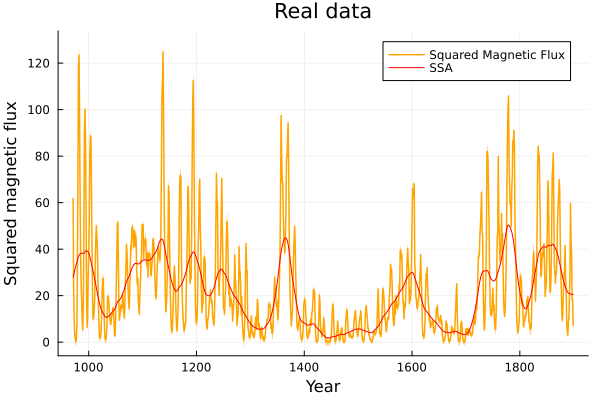

In [38]:
# PLOTTING OF THE OPEN MAGNETIC FLUX RECORDS FROM 971 TO 1899 (AD)

Plots.plot(data.year, data.open_magn_flux.^2, ribbon = data.open_magn_flux_err.^2, xlabel = "Year", ylabel = "Squared magnetic flux", 
    title = "Real data", label = "Squared Magnetic Flux", linewidth = 1.5, color = "orange")
Plots.plot!(data.year, data.ssa_open_magn_flux.^2, label = "SSA", linewidth = 1, color = "red")

In [36]:
# Function to plot the fourier spectrum of simulated data
function plot_fourier_spectrum(t::Vector{Float64}, u::Vector{Float64})
  Fs = 1 / (t[2] - t[1])
  N = length(u)
  freqs = fftfreq(N, Fs)

  fourier_transform_sim = abs.(fft(u))

  frequencies = freqs[(freqs .>= 0) .& (freqs .<= 0.5)]
  amplitudes = abs.(fourier_transform_sim[(freqs .>= 0) .& (freqs .<= 0.5)])

  p = Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Magnitude Spectrum", legend=false)
  vline!(p, [1/11], line=:dash, color=:red, label=false)
  display(p)
end

plot_fourier_spectrum (generic function with 1 method)

In [1]:
plot_fourier_spectrum(data.year, data.open_magn_flux.^2)

UndefVarError: UndefVarError: `data` not defined

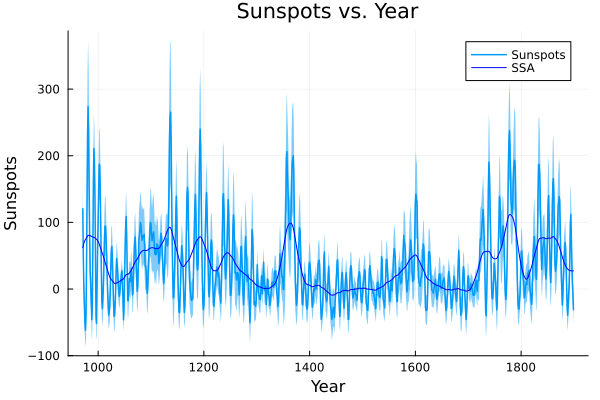

In [4]:
# PLOTTING OF THE SUNSPOT RECORDS FROM 971 TO 1899 (AD)

Plots.plot(data.year, data.sunspots_num, ribbon = data.sunspots_err, xlabel = "Year", ylabel = "Sunspots", 
    title = "Sunspots vs. Year", label = "Sunspots", linewidth = 1.5)
Plots.plot!(data.year, data.ssa_sunspots, label = "SSA", linewidth = 1, color = "blue")

In [5]:
# Box-shaped function for the magnetic field range 
function f(B, B_max = 10, B_min = 1)
  return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Drift function for the DDE
function drift(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  lags = (T,)
  Bhist = h(p, t - lags[1])[1]
  B, dB = u

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + (N / tau^2) * Bhist * f(Bhist, Bmax))
end

# Noise function for the DDE
function noise!(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = 0
  du[2] = (sigma * Bmax)/(tau^(3/2))
end

# SDDE problem solver
function bfield_new(θ, Tsim, dt)
	τ, T, Nd, sigma, Bmax = θ
  lags = (T, )
	h(p, t) = [Bmax, 0.]
  B0 = [Bmax, 0.]
	tspan = (Tsim[1], Tsim[2])

	prob = SDDEProblem(drift, noise!, B0, h, tspan, θ; constant_lags = lags)
	solve(prob, EM(), dt = dt, saveat = 1.0)
end

bfield_new (generic function with 1 method)

In [6]:
# SIMULATED DATA PARAMETERS MANAGING

# Parameters for the simulated data
N = 6.2
T = 3.1
tau = 3.5
sigma = 0.04
B_max = 6.0

par = [N, T, tau, sigma, B_max]

# Time
Tsim = [971, 1899]
dt = 0.1

0.1

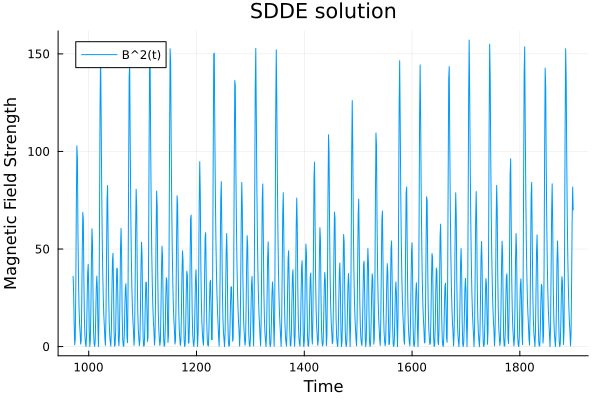

In [15]:
sol = bfield_new(par, Tsim, dt)

# Plot 
Plots.plot(sol.t, sol[1, :].^2, label = "B^2(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "SDDE solution", linewidth = 1)

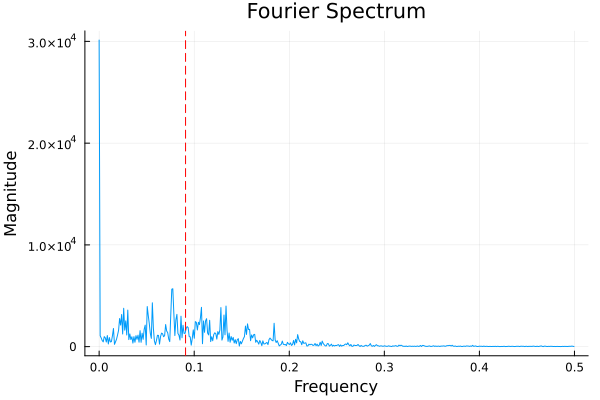

In [18]:
t = sol.t
u = sol[1, :].^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .>= 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .>= 0) .& (freqs .<= 0.5)])

p = Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Fourier Spectrum", legend=false)
vline!(p, [1/11], line=:dash, color=:red, label=false)

display(p)

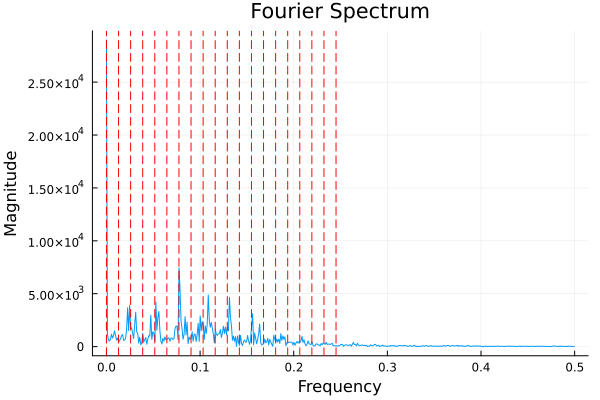

In [13]:
Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, 1/Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .>= 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .>= 0) .& (freqs .<= 0.5)])

p = Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Fourier Spectrum", legend=false)

# Plot vertical lines at specified positions (within the range 0-0.5)
seq = 0:1:length(frequencies)
seq = seq / length(frequencies)
v_line = 1:6:120

for pos in v_line
    vline!(p, [seq[pos]], line=:dash, color=:red, label=false)
end

display(p)

In [10]:
include("./SDDESolarDynamo.jl")
using .SDDESolarDynamo